In [27]:
#libraries
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import math as math
from scipy.optimize import root_scalar
from scipy.optimize import fsolve
from matplotlib.ticker import ScalarFormatter

In [28]:
# Set global theme settings for plotting
plt.rcParams.update({
    'font.size': 20,          # Set font size
    'lines.linewidth': 3,     # Set default line thickness
    'axes.titlesize': 20,     # Title font size
    'axes.labelsize': 18,     # Axis label font size
    'xtick.labelsize': 14,    # X-tick label font size
    'ytick.labelsize': 14,    # Y-tick label font size
    'grid.color': 'gray',     # Grid color
    'grid.linestyle': '--',   # Grid line style
    'grid.linewidth': 0.5,    # Grid line width
    'legend.fontsize': 16     # Legend font size
})

In [29]:
#Arguments used to calculate Ne
#20000 human genes, each human gene is a linkage block
totallinkageblocks = 20000
chromosomenumber=23

humanUd = [2.0, 10.0]
Kimetalsd=0.009
Boykoetalsd=0.029

log10humanUd = np.log10(humanUd)
Udcolor = '#009E73'
log10Kim = np.log10(Kimetalsd)
Kimcolor = '#E69F00'
log10Boyko = np.log10(Boykoetalsd)
Boykocolor = '#56B4E9'

N1=200
N1color = '#F0E442'
N2=2000
N2color = '#CC79A7'
N3=20000
N3color = '#D55E00'

deterministiccolor = 'black'


In [30]:
#function returns Ne as in Matheson and Masel 2024. 
#r=2 per chromosome, two recombination events for chromosome arm
def calculate_Ne(Ud, sh, totallinkageblocks, chromosomenumber, N):
  Ne = N*np.exp(-8*Ud*(1-(1/totallinkageblocks))*sh)*np.exp(-Ud/(chromosomenumber*2))
  return Ne

#working on this, check that the signs of the math work first
def PfixDFE(x, Ud, sd, totallinkageblocks, chromosomenumber, N):
  Ne = calculate_Ne(Ud, sd, totallinkageblocks, chromosomenumber, N)
  Pfix = (1-np.exp(-x, dtype=np.float128))/(1-np.exp(-4*Ne*(-x), dtype=np.float128))
  DFE = np.exp(-x/(sd), dtype=np.float128)/sd
  return Pfix*DFE

def calculate_PfixDFE(Ud, sd, totallinkageblocks, chromosomenumber, N):
  result = integrate.quad(PfixDFE, 0, 1, args=(Ud, sd, totallinkageblocks, chromosomenumber, N))
  return abs(result[0])

#Next function has to be zero to find the point where deterministic and stochastic accumulation equals each other
def calculate_stochastic_accumulation(Ud, sd, totallinkageblocks, chromosomenumber, N):
  stochastic_accumulation = Ud*N*calculate_PfixDFE(Ud, sd, totallinkageblocks, chromosomenumber, N)
  return stochastic_accumulation

#Calculate deterministic mutation accumulation
def calculate_deterministic_accumulation(Ud, sh):
  deterministic_accumulation = Ud*(1-(1/(4.9*np.sqrt(Ud*sh))))
  return deterministic_accumulation

#Next function has to be zero to find the point where deterministic and stochastic accumulation equals each other
def calculate_deterministic_contribution(Ud, sh):
  deterministic_contribution = 1-(1/(4.9*np.sqrt(Ud*sh)))
  return deterministic_contribution

def find_Udroot_deterministic(sd, x0):
  result = fsolve(lambda Ud: calculate_deterministic_contribution(Ud, sd), x0)
  return result

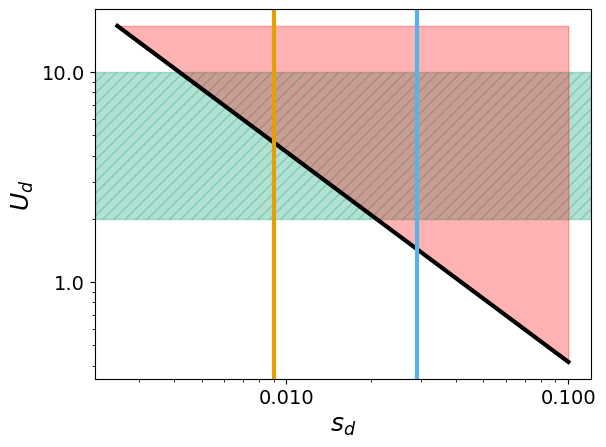

In [31]:
#Roots for the deterministic accumulation equation

sd = np.logspace(-2.6, -1, 100)
vUdroot_det = np.vectorize(find_Udroot_deterministic)
Udroot1 = vUdroot_det(sd, 0.2)
log10sd = np.log10(sd)
log10Udroot1 = np.log10(Udroot1)

plt.plot(sd, Udroot1, color = deterministiccolor)
plt.axvline(x = Kimetalsd, color = Kimcolor, label = 'Kimetal')
plt.axvline(x = Boykoetalsd, color = Boykocolor, label = 'Boyko')
plt.axhspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.3, hatch="///")
plt.fill_between(sd, y1=Udroot1, y2=max(Udroot1), color="red", alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.xlabel(r"$s_{d}$")
plt.ylabel(r"$U_{d}$")
plt.savefig('graphs/deterministic_mutationaccumulation.png', dpi=300)

/tmp/ipykernel_134760/1996804443.py:10: RuntimeWarning: overflow encountered in exp
  Pfix = (1-np.exp(-x, dtype=np.float128))/(1-np.exp(-4*Ne*(-x), dtype=np.float128))


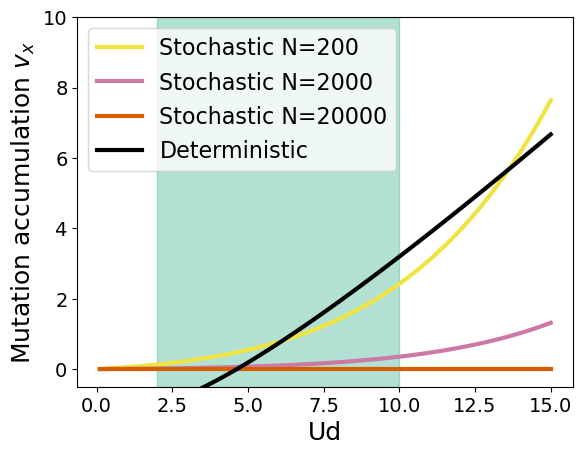

In [32]:
#accumulation contribution for Kim et al 
Ud = np.linspace(start=0.1, stop=15, num=100)
deterministic_acc = calculate_deterministic_accumulation(Ud, Kimetalsd)
vStochastic_acc = np.vectorize(calculate_stochastic_accumulation)

stochastic_acc_N1 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N1)
stochastic_acc_N2 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N2)
stochastic_acc_N3 = vStochastic_acc(Ud, Kimetalsd, totallinkageblocks, chromosomenumber, N3)

stochastic_label = 'Stochastic N='
deterministic_label = 'Deterministic'
Kimplot = plt.figure()
plt.plot(Ud, stochastic_acc_N1, label = f"{stochastic_label}{N1}", color = N1color)
plt.plot(Ud, stochastic_acc_N2, label = f"{stochastic_label}{N2}", color = N2color)
plt.plot(Ud, stochastic_acc_N3, label = f"{stochastic_label}{N3}", color = N3color)
plt.plot(Ud, deterministic_acc, label = deterministic_label, color = deterministiccolor)
plt.legend()
plt.xlabel('Ud')
plt.ylabel(r"Mutation accumulation $v_{x}$")
plt.ylim(-0.5, 10) 
plt.axvspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.3)
plt.savefig('graphs/Kimsd_mutationaccumulation.png', dpi=300)


/tmp/ipykernel_134760/1996804443.py:10: RuntimeWarning: overflow encountered in exp
  Pfix = (1-np.exp(-x, dtype=np.float128))/(1-np.exp(-4*Ne*(-x), dtype=np.float128))


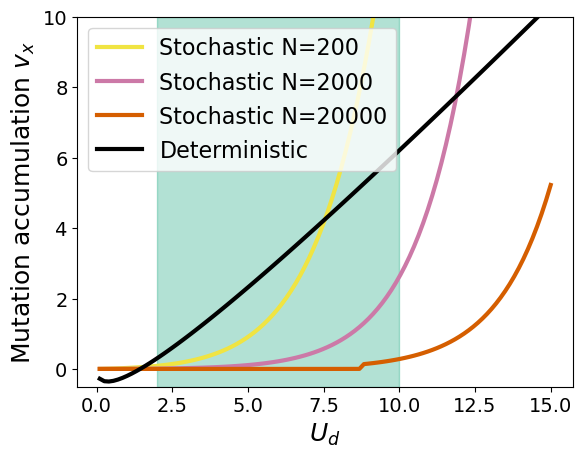

In [33]:
#accumulation contribution for Boyko et al 

Ud = np.linspace(start=0.1, stop=15, num=100)
deterministic_acc = calculate_deterministic_accumulation(Ud, Boykoetalsd)
vStochastic_acc = np.vectorize(calculate_stochastic_accumulation)

stochastic_acc_N1 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N1)
stochastic_acc_N2 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N2)
stochastic_acc_N3 = vStochastic_acc(Ud, Boykoetalsd, totallinkageblocks, chromosomenumber, N3)

stochastic_label = 'Stochastic N='
deterministic_label = 'Deterministic'
Boykoplot = plt.figure()
plt.plot(Ud, stochastic_acc_N1, label = f"{stochastic_label}{N1}", color = N1color)
plt.plot(Ud, stochastic_acc_N2, label = f"{stochastic_label}{N2}", color = N2color)
plt.plot(Ud, stochastic_acc_N3, label = f"{stochastic_label}{N3}", color = N3color)
plt.plot(Ud, deterministic_acc, label = deterministic_label, color = deterministiccolor)
plt.legend()
plt.xlabel(r"$U_{d}$")
plt.ylabel(r"Mutation accumulation $v_{x}$")
plt.ylim(-0.5, 10) 
plt.axvspan(humanUd[0], humanUd[1], color=Udcolor, alpha=0.3)
plt.savefig('graphs/Boykosd_mutationaccumulation.png', dpi=300)